In [ ]:
!pip install ultralytics
!pip install super-gradients
!pip install timm==0.6.12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls
%cd /content/drive/MyDrive/data
!ls

drive  sample_data  yolov8n.pt
/content/drive/.shortcut-targets-by-id/1-o0GijxGF4EhhZGRwn5mXXvJRCGwsFPV/Quay ỉa
config.yaml   IMG_5277.MOV  IMG_5284.MOV  IMG_5290.MOV	mytest			   test.mp4
for_test.mp4  IMG_5278.MOV  IMG_5285.MOV  IMG_5291.MOV	output_BoT-SORT_test.mp4   train
image	      IMG_5280.MOV  IMG_5286.MOV  IMG_5292.MOV	output_ByteTrack_test.mp4  yolov7-e6.yaml
IMG	      IMG_5281.MOV  IMG_5287.MOV  IMG_5293.MOV	runs			   yolov8n.pt
IMG_5275.MOV  IMG_5282.MOV  IMG_5288.MOV  IMG_5294.MOV	test			   yolov8x.pt
IMG_5276.MOV  IMG_5283.MOV  IMG_5289.MOV  my_test	test_1.mp4


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:

from IPython.display import display, Javascript, Image
# JavaScript to properly create our live video stream using our webcam as input

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'Bấm vào video để dừng';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


In [ ]:
import PIL
import io
from base64 import b64decode, b64encode

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


In [ ]:
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from collections import defaultdict
import numpy as np
import cv2

video_stream()

bbox = ' '
count = 0

track_history = defaultdict(lambda: [])

while True:
  js_reply = video_frame('test', bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  #get results from model tracking
  results = model.track(frame, persist=True)


  # Get the boxes and track IDs
  boxes = results[0].boxes.xywh.cpu()
  track_ids = results[0].boxes.id.int().cpu().tolist()

  # Visualize the results on the frame
  annotated_frame = results[0].plot()

  # Plot the tracks
  for box, track_id in zip(boxes, track_ids):
    x, y, w, h = box
    track = track_history[track_id]
    track.append((float(x), float(y)))  # x, y center point
    if len(track) > 30:  # retain 90 tracks for 90 frames
        track.pop(0)

    # Draw the tracking lines
    points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
    # bbox_array = cv2.polylines(bbox_array, [points], isClosed=False, color=(230, 230, 230), thickness=10)

    left = int(int(x) - (int(w)/2))
    right = int (int(y) - (int(h)/2))
    width = int(w)
    height = int(h)


    bbox_array = cv2.rectangle(bbox_array,(left,right),(left+width,right+height),(255,0,0),2)
    bbox_array = cv2.putText(bbox_array,str(track_id),(left,right), cv2.FONT_HERSHEY_SIMPLEX, 0.5,color=(0, 230,0), thickness=10)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes




<IPython.core.display.Javascript object>


0: 480x640 1 person, 22.0ms
Speed: 1.7ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 33.9ms
Speed: 3.8ms preprocess, 33.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 32.9ms
Speed: 1.7ms preprocess, 32.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 22.2ms
Speed: 2.9ms preprocess, 22.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 24.9ms
Speed: 1.9ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 frisbee, 38.2ms
Speed: 1.8ms preprocess, 38.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 30.2ms
Speed: 1.6ms preprocess, 30.2ms inference, 21.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 19.5ms
Speed: 1.7ms preprocess, 19.5ms inference, 1.9ms postprocess per image at sha

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))

  frame = js_to_image(js_reply['img'])
  # Run YOLOv8 inference on the frame
  results = model(frame)

  # Visualize the results on the frame
  annotated_frame = results[0].plot()

  # Display the annotated frame
  cv2.imwrite(filename, annotated_frame)

  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

string indices must be integers


In [ ]:
from ultralytics import NAS

# Load the YOLOv8 model
model = NAS('/content/drive/MyDrive/yolo/yolo_nas_s.pt')

# Display model information (optional)
model.info()

## Test track using gpu of google coble

In [ ]:
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from collections import defaultdict
import numpy as np
import cv2

video_stream()

bbox = ' '
count = 0

track_history = defaultdict(lambda: [])

while True:
  js_reply = video_frame('test', bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  #model call
  results = model.track(data='coco8.yaml')
  #get results from model tracking
  results = model(frame)


  # Get the boxes and track IDs
  boxes = results[0].boxes.xywh.cpu()
  track_ids = results[0].boxes.id.int().cpu().tolist()

  # Visualize the results on the frame
  annotated_frame = results[0].plot()

  # Plot the tracks
  for box, track_id in zip(boxes, track_ids):
    x, y, w, h = box
    track = track_history[track_id]
    track.append((float(x), float(y)))  # x, y center point
    if len(track) > 30:  # retain 90 tracks for 90 frames
        track.pop(0)

    # Draw the tracking lines
    points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
    # bbox_array = cv2.polylines(bbox_array, [points], isClosed=False, color=(230, 230, 230), thickness=10)

    left = int(int(x) - (int(w)/2))
    right = int (int(y) - (int(h)/2))
    width = int(w)
    height = int(h)


    bbox_array = cv2.rectangle(bbox_array,(left,right),(left+width,right+height),(255,0,0),2)
    bbox_array = cv2.putText(bbox_array,str(track_id),(left,right), cv2.FONT_HERSHEY_SIMPLEX, 0.5,color=(0, 230,0), thickness=10)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

#Train

## Start train

In [ ]:
from ultralytics import YOLO

# highest reliability model
model = YOLO('yolov8x.pt')

# train vs file setup khoản 1 100 epochs, với kích thức ảnh được resize lại: 640
results = model.train(data='config.yaml', epochs=100, imgsz=640)

In [ ]:
!yolo train model=yolov6l6.pt data=config.yaml epochs=100 imgsz=640

## Continute train

In [ ]:
from ultralytics import YOLO


model = YOLO('/content/drive/MyDrive/data/runs/detect/train/weights/best.pt')

results = model.train(data='config.yaml', epochs=50, imgsz=640)



Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/data/runs/detect/train/weights/best.pt, data=config.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, 

train: Scanning /content/drive/.shortcut-targets-by-id/1-o0GijxGF4EhhZGRwn5mXXvJRCGwsFPV/Quay ỉa/train/labels.cache... 1002 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1005/1005 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1-o0GijxGF4EhhZGRwn5mXXvJRCGwsFPV/Quay ỉa/train/labels.cache... 1002 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1005/1005 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:01<?, ?it/s]


OutOfMemoryError: ignored

# TEST trained model


image 1/1 /content/drive/MyDrive/data/image/500.jpg: 480x640 1 nuoc rua chen sunlight, 1 banh oishi snack tom cay nong, 1 dau an good meal, 1 nuoc tuong Huong Viet, 1 nuoc nam De Nhi, 1 but bi xanh, 62.1ms
Speed: 1.6ms preprocess, 62.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


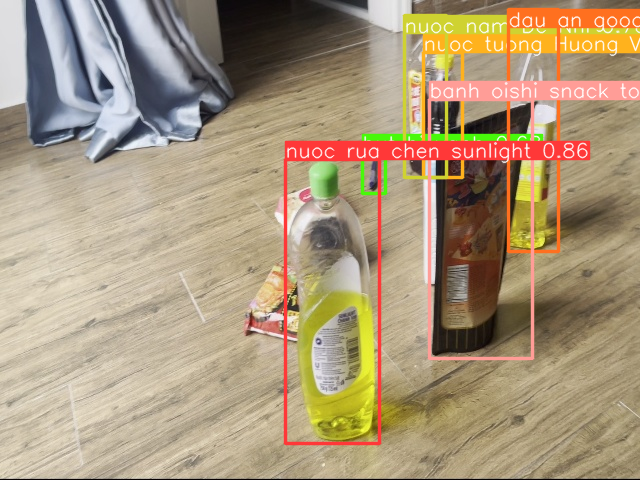

In [ ]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2


model = YOLO('/content/drive/MyDrive/data/runs/detect/train/weights/best.pt')

results = model('/content/drive/MyDrive/data/image/500.jpg')
# Visualize the results on the frame
annotated_frame = results[0].plot()

# # Display the annotated frame
cv2_imshow(annotated_frame)

In [ ]:


cap = cv2.VideoCapture("/content/drive/MyDrive/data/IMG_5275.MOV")
ret, frame = cap.read()
H, W, _ = frame.shape
out = cv2.VideoWriter('/content/drive/MyDrive/data/test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

# Load a model
model = YOLO('/content/drive/MyDrive/data/runs/detect/train/weights/best.pt')

threshold = 0.5

while ret:

    results = model(frame)[0]

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 1 nuoc rua chen sunlight, 1 banh oishi snack tom cay nong, 1 dau an good meal, 1 nuoc tuong Huong Viet, 1 nuoc nam De Nhi, 1 but bi xanh, 1 khan giay uot mamamy, 1 coco tay te bao chet, 1 mi goi kokomi 90g, 1 sua rua mat Cerave, 61.7ms
Speed: 3.4ms preprocess, 61.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nuoc rua chen sunlight, 1 banh oishi snack tom cay nong, 1 dau an good meal, 1 nuoc tuong Huong Viet, 1 nuoc nam De Nhi, 1 but bi xanh, 1 khan giay uot mamamy, 1 coco tay te bao chet, 1 mi goi kokomi 90g, 1 sua rua mat Cerave, 37.8ms
Speed: 3.8ms preprocess, 37.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nuoc rua chen sunlight, 1 banh oishi snack tom cay nong, 1 dau an good meal, 1 nuoc tuong Huong Viet, 1 nuoc nam De Nhi, 1 but bi xanh, 1 khan giay uot mamamy, 1 coco tay te bao chet, 1 mi goi kokomi 90g, 1 sua rua mat Cerave, 45.5ms
Speed: 3.1ms preprocess, 45.5ms inference, 1.8ms postprocess p

# DEEP SORT

In [ ]:
%cd /content/drive/MyDrive/data

/content/drive/.shortcut-targets-by-id/1-o0GijxGF4EhhZGRwn5mXXvJRCGwsFPV/Quay ỉa


In [ ]:
# clone deepsort testing project
!git clone https://github.com/AarohiSingla/Tracking-and-counting-Using-YOLOv8-and-DeepSORT.git my_test

/content/drive/.shortcut-targets-by-id/1-o0GijxGF4EhhZGRwn5mXXvJRCGwsFPV/Quay ỉa
fatal: destination path 'mytest' already exists and is not an empty directory.


In [ ]:
!ls

config.yaml   IMG_5277.MOV  IMG_5284.MOV  IMG_5290.MOV	mytest			  train
for_test.mp4  IMG_5278.MOV  IMG_5285.MOV  IMG_5291.MOV	output_deepsort_test.mp4  yolov7-e6.yaml
image	      IMG_5280.MOV  IMG_5286.MOV  IMG_5292.MOV	runs			  yolov8n.pt
IMG	      IMG_5281.MOV  IMG_5287.MOV  IMG_5293.MOV	test			  yolov8x.pt
IMG_5275.MOV  IMG_5282.MOV  IMG_5288.MOV  IMG_5294.MOV	test_1.mp4
IMG_5276.MOV  IMG_5283.MOV  IMG_5289.MOV  my_test	test.mp4


In [ ]:
from my_test.deep_sort.utils.parser import get_config
from my_test.deep_sort.deep_sort import DeepSort
from my_test.deep_sort.sort.tracker import Tracker

In [ ]:
deep_sort_weights = 'my_test/deep_sort/deep/checkpoint/ckpt.t7'
tracker = DeepSort(model_path=deep_sort_weights, max_age=70)

## Test deepsort

In [ ]:
from ultralytics import YOLO

import time
import torch
import cv2
import torch.backends.cudnn as cudnn
from PIL import Image
import colorsys
import numpy as np

# Define the video path
video_path = 'for_test.mp4'

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Get the video properties
H, W, _ = frame.shape

# Define the codec and create VideoWriter object
output_path = 'output_deepsort_test.mp4'
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
frames = []

unique_track_ids = set()
i = 0
counter, fps, elapsed = 0, 0, 0
start_time = time.perf_counter()

while cap.isOpened():
    ret, frame = cap.read()

    if ret:

        og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = og_frame.copy()

        model = YOLO('runs/detect/train/weights/best.pt')  # load a trained model

        #get results from model tracking
        results = model(frame)

        class_names = ['nuoc rua chen sunlight', 'banh oishi snack tom cay nong', 'banh oishi snack tom cay nong', 'banh oishi snack tom cay nong', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi']


        for result in results:
            boxes = result.boxes  # Boxes object for bbox outputs
            probs = result.probs  # Class probabilities for classification outputs
            cls = boxes.cls.tolist()  # Convert tensor to list
            xyxy = boxes.xyxy
            conf = boxes.conf
            xywh = boxes.xywh  # box with xywh format, (N, 4)
            for class_index in cls:
                class_name = class_names[int(class_index)]
                #print("Class:", class_name)

        pred_cls = np.array(cls)
        conf = conf.detach().cpu().numpy()
        xyxy = xyxy.detach().cpu().numpy()
        bboxes_xywh = xywh
        bboxes_xywh = xywh.cpu().numpy()
        bboxes_xywh = np.array(bboxes_xywh, dtype=float)

        tracks = tracker.update(bboxes_xywh, conf, og_frame)

        for track in tracker.tracker.tracks:
            track_id = track.track_id
            hits = track.hits
            x1, y1, x2, y2 = track.to_tlbr()  # Get bounding box coordinates in (x1, y1, x2, y2) format
            w = x2 - x1  # Calculate width
            h = y2 - y1  # Calculate height

            # Set color values for red, blue, and green
            red_color = (0, 0, 255)  # (B, G, R)
            blue_color = (255, 0, 0)  # (B, G, R)
            green_color = (0, 255, 0)  # (B, G, R)

            # Determine color based on track_id
            color_id = track_id % 3
            if color_id == 0:
                color = red_color
            elif color_id == 1:
                color = blue_color
            else:
                color = green_color

            cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

            text_color = (0, 0, 0)  # Black color for text
            cv2.putText(og_frame, f"{class_name}-{track_id}", (int(x1) + 10, int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

            # Add the track_id to the set of unique track IDs
            unique_track_ids.add(track_id)

        # Update the person count based on the number of unique track IDs
        person_count = len(unique_track_ids)


        # Update FPS and place on frame
        current_time = time.perf_counter()
        elapsed = (current_time - start_time)
        counter += 1
        if elapsed > 1:
            fps = counter / elapsed
            counter = 0
            start_time = current_time

        # Draw person count on frame
        cv2.putText(og_frame, f"Person Count: {person_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Append the frame to the list
        frames.append(og_frame)

        # Write the frame to the output video file
        out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))

        # Show the frame
        #cv2.imshow("Video", og_frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 (no detections), 64.2ms
Speed: 2.1ms preprocess, 64.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.5ms
Speed: 1.8ms preprocess, 63.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 49.9ms
Speed: 1.8ms preprocess, 49.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 49.2ms
Speed: 1.9ms preprocess, 49.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 60.2ms
Speed: 1.8ms preprocess, 60.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.8ms
Speed: 2.1ms preprocess, 63.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 52.2ms
Speed: 2.2ms preprocess, 52.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.6ms
Speed: 1.8ms preprocess, 63.6ms i

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-8136f0133b34>", line 33, in <cell line: 32>
    ret, frame = cap.read()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", 

# Main func
## push func
  update data to api for view render by push methor

In [ ]:
def push():
  pass

In [ ]:
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from collections import defaultdict
import numpy as np
import cv2

video_stream()

bbox = ' '
count = 0

# set for id
unique_track_ids = set()
store = unique_track_ids.copy()
track_history = defaultdict(lambda: [])

while True:
  js_reply = video_frame('test', bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  #prepare frame
  og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = og_frame.copy()

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

   # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  model = YOLO('runs/detect/train/weights/best.pt')  # load a trained model

  #get results from model tracking
  results = model(frame)

  class_names = ['nuoc rua chen sunlight', 'banh oishi snack tom cay nong', 'banh oishi snack tom cay nong', 'banh oishi snack tom cay nong', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi', 'nuoc nam De Nhi']

  # Get the boxes and track IDs
  # boxes = results[0].boxes.xywh.cpu()
  # track_ids = results[0].boxes.id.int().cpu().tolist()

  # get result
  for result in results:
            boxes = result.boxes  # Boxes object for bbox outputs
            probs = result.probs  # Class probabilities for classification outputs
            cls = boxes.cls.tolist()  # Convert tensor to list
            xyxy = boxes.xyxy
            conf = boxes.conf
            xywh = boxes.xywh  # box with xywh format, (N, 4)
            for class_index in cls:
                class_name = class_names[int(class_index)]
                #print("Class:", class_name)

  # convert result to numpy
  pred_cls = np.array(cls)
  conf = conf.detach().cpu().numpy()
  xyxy = xyxy.detach().cpu().numpy()
  bboxes_xywh = xywh
  bboxes_xywh = xywh.cpu().numpy()
  bboxes_xywh = np.array(bboxes_xywh, dtype=float)

  # sort result width deepsort
  tracks = tracker.update(bboxes_xywh, conf, og_frame)
  for track in tracker.tracker.tracks:
            track_id = track.track_id
            hits = track.hits
            x1, y1, x2, y2 = track.to_tlbr()  # Get bounding box coordinates in (x1, y1, x2, y2) format
            w = x2 - x1  # Calculate width
            h = y2 - y1  # Calculate height

            # Set color values for red, blue, and green
            red_color = (0, 0, 255)  # (B, G, R)
            blue_color = (255, 0, 0)  # (B, G, R)
            green_color = (0, 255, 0)  # (B, G, R)

            # Determine color based on track_id
            color_id = track_id % 3
            if color_id == 0:
                color = red_color
            elif color_id == 1:
                color = blue_color
            else:
                color = green_color

            cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

            text_color = (0, 0, 0)  # Black color for text
            cv2.putText(og_frame, f"{class_name}-{track_id}", (int(x1) + 10, int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

            # Add the track_id to the set of unique track IDs
            unique_track_ids.add((class_name,track_id))
            if store != unique_track_ids:
              store = unique_track_ids.copy()
              push()

  # Update the count based on the number of unique track IDs
  count = len(unique_track_ids)


phần deep cut rồi


viết lại ở đây
Dùng ByteTrack


In [ ]:
import cv2
from ultralytics import YOLO

# Load the YOLOv8 model

model = YOLO('runs/detect/train/weights/best.pt')  # load a trained model

# Open the video file
video_path = 'for_test.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Get the video properties
H, W, _ = frame.shape

# Define the codec and create VideoWriter object
output_path = 'output_ByteTrack_test.mp4'
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))


# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()


    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, persist=True, conf=0.5, iou=0.5, tracker="bytetrack.yaml")

        # Visualize the results on the frame
        annotated_frame = results[0].plot()
        out.write(annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 (no detections), 2714.6ms
Speed: 2.7ms preprocess, 2714.6ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2838.3ms
Speed: 2.3ms preprocess, 2838.3ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4337.6ms
Speed: 3.7ms preprocess, 4337.6ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3717.3ms
Speed: 3.7ms preprocess, 3717.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2654.2ms
Speed: 4.1ms preprocess, 2654.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2634.9ms
Speed: 2.6ms preprocess, 2634.9ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 2631.1ms
Speed: 2.5ms preprocess, 2631.1ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3788.6ms
Spe

## ghost sever multidetect

In [ ]:
import requests

def post_to_api(url, data, headers=None):
    """
    Sends a POST request to the specified API.

    Parameters:
    - url (str): The URL of the API endpoint.
    - data (dict): The data to be sent in the request body.
    - headers (dict, optional): Additional headers for the request.

    Returns:
    - response: The response object returned by the API.
    """
    response = requests.post(url, json=data, headers=headers)
    return response

# Example usage:
api_url = "https://jsonplaceholder.typicode.com/posts"
payload_data = {"title": "foo", "body": "bar", "userId": "1"}
response = post_to_api(api_url, payload_data)

print(response.status_code)
print(response.json())

201
{'title': 'foo', 'body': 'bar', 'userId': '1', 'id': 101}


In [ ]:

def post(id, cls, taken):
  # api_url = "https://jsonplaceholder.typicode.com/posts"
  api_url = "http://myapi/posts"
  # payload_data = {"Productid": id, "name": cls}
  # class_names = ['nuoc rua chen sunlight', 'banh oishi snack tom cay nong', 'dau an good meal', 'nuoc tuong Huong Viet', 'nuoc nam De Nhi', 'but bi xanh,', ' khan giay uot mamamy', 'coco tay te bao chet', 'mi goi kokomi 90g', 'duong am Cerave']
  prices = ['24,300', '12.000', '41.000', '6.600', '25.000', '7,650', '21,000', '115.000', '4,500', '370.000']
  unit = ['chai', 'bich', 'chai', 'chai', 'chai', 'cay', 'bich', 'hu', 'goi', 'hu']
  payload_data = {"id":id,"name":cls,"price":price[cls],"units":unit[cls],"taken":taken,"payable":taken}
  response = post_to_api(api_url, payload_data)

  print(response.status_code)
  print(response.json())

In [ ]:
import cv2
from ultralytics import YOLO
from collections import defaultdict
import numpy as np

# Load the YOLOv8 model

model = YOLO('runs/detect/train/weights/best.pt')  # load a trained model

# Open the video file
video_path = 'for_test.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Get the video properties
H, W, _ = frame.shape

# Define the codec and create VideoWriter object
output_path = 'output_BoT-SORT_test.mp4'
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

# Store the track history
track_history = defaultdict(lambda: [])

# item store
track_history_items = defaultdict(lambda: [])

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()


    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, persist=True, conf=0.7, iou=0.5)

        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        #class name
        class_names = ['nuoc rua chen sunlight', 'banh oishi snack tom cay nong', 'dau an good meal', 'nuoc tuong Huong Viet', 'nuoc nam De Nhi', 'but bi xanh,', ' khan giay uot mamamy', 'coco tay te bao chet', 'mi goi kokomi 90g', 'duong am Cerave']

       if results[0].boxes.id is not None:
          track_ids = results[0].boxes.id.int().cpu().tolist()
          for track_id in track_ids:
              if track_id not in track_history:
                  cls = results[0].boxes.cls.int().cpu().tolist()
                  for i in range(len(cls)):
                      current_cls = cls[i]
                      current_track_id = track_id
                      current_item = (current_cls, current_track_id)

                      if current_item not in track_history_items:
                          store = track_history_items[current_item]  # Using current_item as a key
                          class_name = class_names[current_cls]

                          # Check if the class name is not already in the store
                          if class_name not in store:
                              store.append(class_name)

                              # Assuming you want to print the content of track_history_items
                              for key, value in track_history_items.items():
                                  print(f"Key: {key}, Value: {value}")

                              # Assuming you want to post something with current_cls, class_name, and the count of items in store
                              post(current_cls, class_name, len(store))


          # Plot the tracks
          for box, track_id in zip(boxes, track_ids):
              x, y, w, h = box
              track = track_history[track_id]
              track.append((float(x), float(y)))  # x, y center point
              if len(track) > 30:  # retain 90 tracks for 90 frames
                  track.pop(0)

              # Draw the tracking lines
              points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
              cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

        # Display the annotated frame
        out.write(annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 (no detections), 107.9ms
Speed: 2.7ms preprocess, 107.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 51.3ms
Speed: 1.6ms preprocess, 51.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 48.5ms
Speed: 2.4ms preprocess, 48.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 48.6ms
Speed: 2.5ms preprocess, 48.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.7ms
Speed: 2.3ms preprocess, 34.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.3ms
Speed: 2.5ms preprocess, 35.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.8ms
Speed: 2.6ms preprocess, 34.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.8ms
Speed: 1.9ms preprocess, 34.8ms